<a href="https://colab.research.google.com/github/CodingPenguins/ML3/blob/main/Week3_KaggleProject_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction To Deep Learning: Week 3 - CNN Cancer Detection

## Introduction

This Kaggle competition is based on image classification of pixel images in the tif format of tissue potentially containing cancer cells. Alongside with the approx 220k images of the training data set, labels are provided indicating whether the 32x32 pixel center (!) of the provided image contains a cancer cell or not. As such, images might contain cancer cells in their periphery, which do not count as cancer cells in the sense of the Kaggle competition (This breaks any assumption of translation invariance!).
The approx 57.5k test images are not provided with labels, and their purpose is to evaluate the CNN created on the Kaggle platform. Since the competition was already finished before I have started my project, I will create an output CSV for my models and submit it to receive a score - however, the leaderboards are closed.

The aim of this project is to train a Convolutional Neural Network to predict the presence of cancer cells in  the image centre region, starting from a base model and iteratively improving on its metrics by hyperparameter tuning and further modifications.![Kaggle_Submission.png](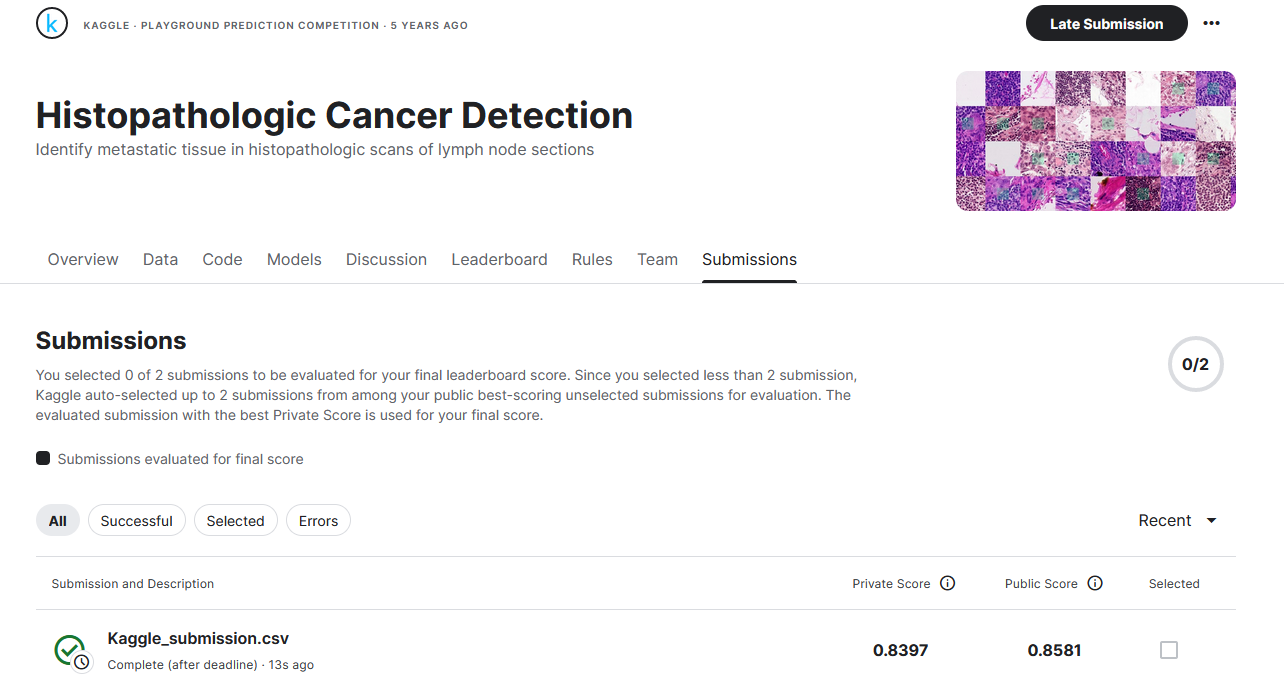![Kaggle_Submission.png](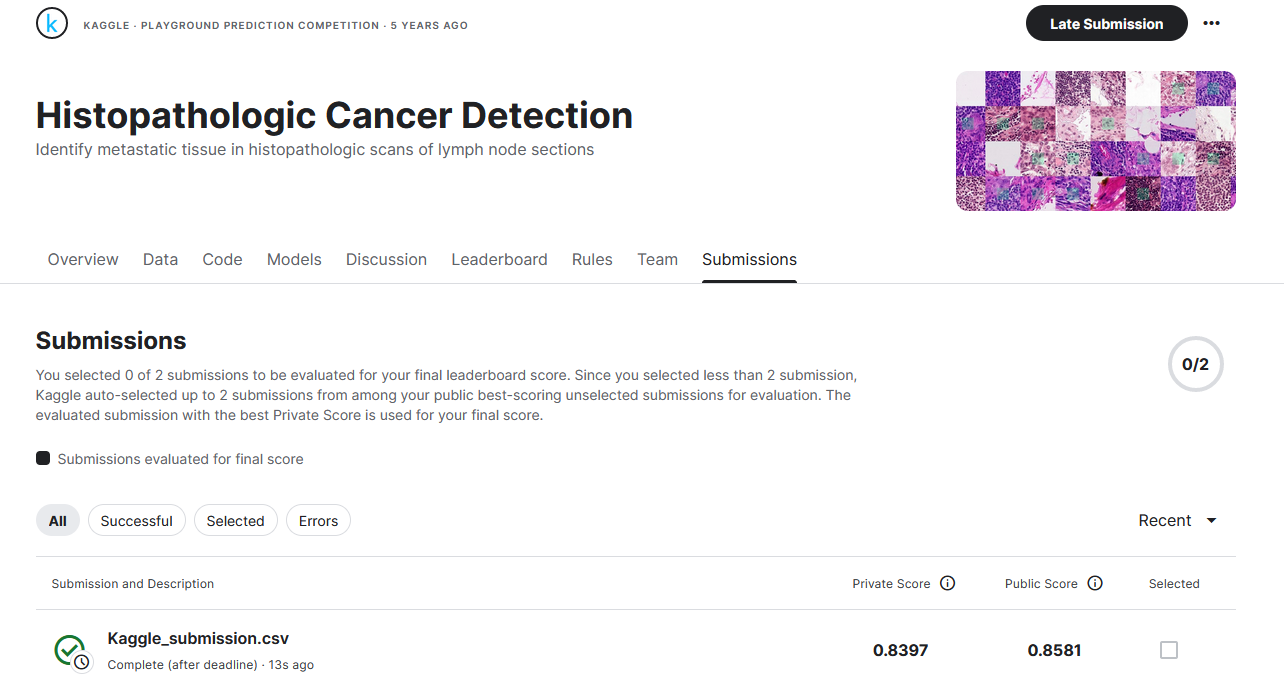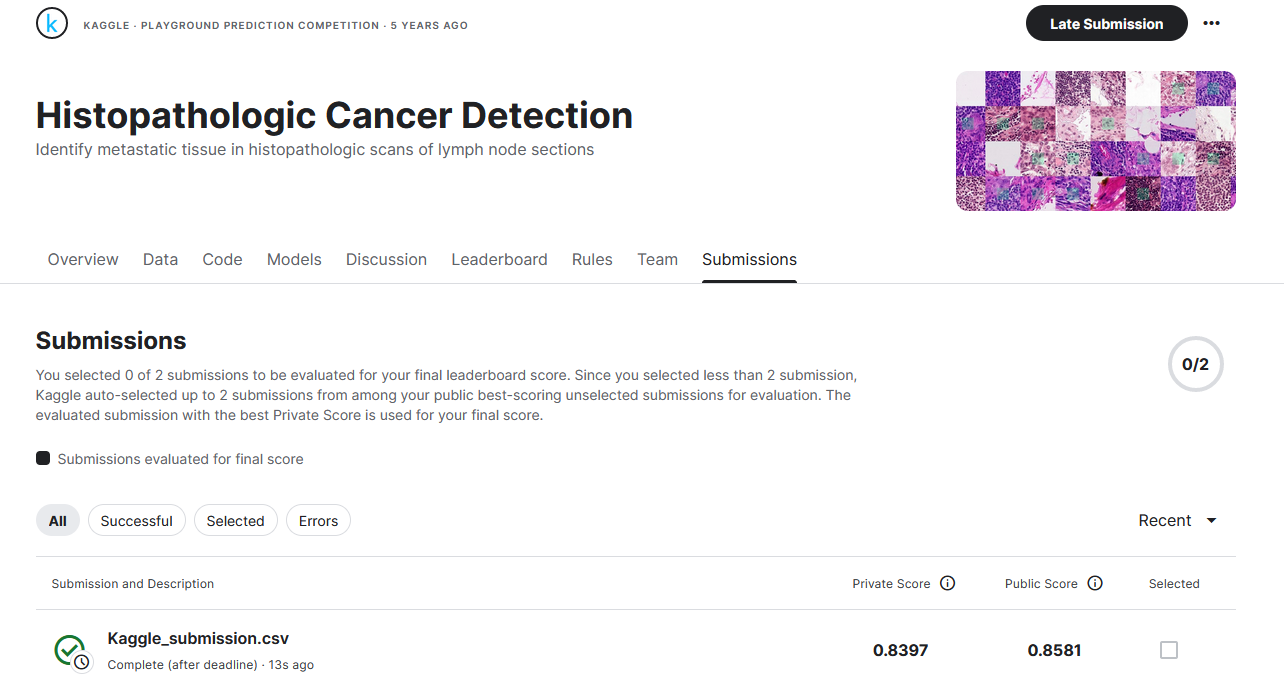))

## EDA

We will use the following libraries:

In [38]:
import matplotlib.pyplot as plt
import numpy as np
#import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall, AUC, MeanSquaredError
import cv2
from google.colab.patches import cv2_imshow #Workaround provided by Google Colab, as cv2_imshow is suppressed
import pandas as pd
import shutil #For moving files in Google Drive

The files have been downloaded from Kaggle to the Google Drive and are accessed when the drive is mounted as follows:

In [7]:
#!pip install kaggle
#import kaggle
import os

os.environ['KAGGLE_USERNAME'] = "codingpenguins" # username from the json file
os.environ['KAGGLE_KEY'] = "DELETED" # key from the json file
!kaggle competitions download -c histopathologic-cancer-detection
path_to_file = "/content/histopathologic-cancer-detection.zip"
!unzip -n "/content/histopathologic-cancer-detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [9]:
path_labels = ("/content/train_labels.csv")
path_train = ("/content/train/")
path_test = ("/content/test/")

Let us look at a sample file of the training data to get a feeling on what we are working with. We will read the tif format using the cv2 library.

In [10]:
sample_file = "/content/train/fffe5fb71a0b57f1c84bc35558e13778e94d1a69.tif" #419337871307507472276372086416eb49e5fefc.tif" #005c46a81d6cce2e4e87cf204c5dc1c47d873c3d.tif"
sample_image = cv2.imread(sample_file)
sample_array = np.asarray(sample_image,dtype = np.float64)

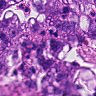

In [11]:
cv2_imshow(sample_image)

In [12]:
sample_array.shape

(96, 96, 3)

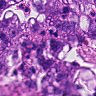

In [13]:
cv2_imshow(sample_array)

So, for a given pixel image, we have an array of size 96x96x3, translating into a square of width=lenght=96 pixel and a depth of 3, which are our RGB colour values. Encoded in the tif format, each image has a size of 28kb.

Let's load our corresponding labels next:

In [14]:
labels = pd.read_csv(path_labels)

In [15]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [16]:
len(labels["id"])

220025

As we can see, each image ID (corresponding to the file name) is provided with a binary label, indicating whether the 32x32 px centre region contains cancer cells.

Before we proceed to load the files, can we perform data cleaning on the images? The data provided in Kaggle is already cleaned and labelled, so we should not encounter e. g. corrupt files. They are also provided in the same format, so we do not need to consider reformating the data. What about the RGB values?

In [17]:
sample_array[1,1,:]

array([117.,  24.,  69.])

Well, as expected, the values are not pre-formated into a more intuitive (and less costly in terms of model training) range from 0 to 1. We should therefore normalized the RGB values accordingly by diving the by 255 later, e. g. in the model.

There are now different ways of how to handle the image data to combine it with the labels. Since we are going to work with the Keras library to construct and train our CNNs, it might be better to let it do the heavy calculation lifting instead of e. g. creating a huge data frame containing all the arrays derived from each image. One way to pass the labels to Keras is by providing it with a list - for that, we would need to make sure that we keep the file directory ordeer, which could produce errors difficult to track. We could opt for creating two directories and sorting the images according to the csv read above: "Cancer" for label = 1, "Healthy" for label = 0. Keras can then derive the labels from the folder structure - however, Google Drive reproducibly times out when performing such operations in directories which so many files. As such, we have to operate on the directly downloaded files - and cannot rely on neatly reordered, pre-saved folder structures.

So, we will simply pass a modified labels data frame to Keras, adding the *.tif extension

In [18]:
labels["id"] = labels["id"] + ".tif"
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [19]:
labels['label2'] = np.where(
    labels['label'] == 0, "healthy", np.where(
    labels['label'] == 1, "cancer", -1))

In [20]:
labels.head()

,id,label,label2
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0,healthy
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,cancer
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0,healthy
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0,healthy
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0,healthy


As part of the preprocessing, we should ask: Are the outcomes symmetrically distributed? Let's plot a histogram:

(array([130908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  89117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

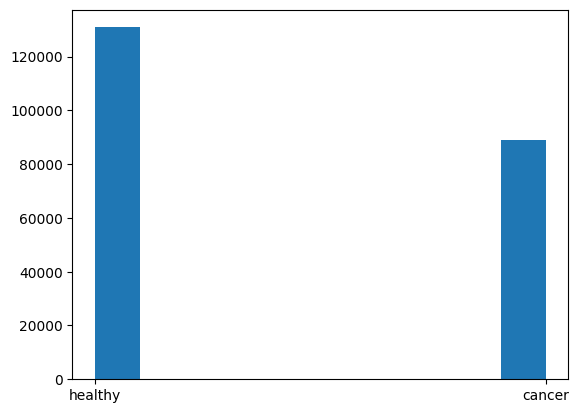

In [44]:
plt.hist(labels["label2"])

In [53]:
print("We have ", len(labels[labels["label2"] == "healthy"]), " training images labelled as healthy and ", len(labels[labels["label2"] == "cancer"]), " as including cancer")
print("Asymmetry ratio is: ", len(labels[labels["label2"] == "cancer"])/len(labels[labels["label2"] == "healthy"]))

We have  130908  training images labelled as healthy and  89117  as including cancer
Asymmetry ratio is:  0.680760534115562


We see that the training data is biased towards healthy images - a fact that we should address by observing e. g. recall and precision in addition to accuracy. We do not want to train a model prone to make type II errors. While we could also drop a certain amount of 'healthy' images, we should rather take the additional accuracy by having more training cases and closely monitor recall.

# Model building

So, for our first model, we apply the rescaling of the RGB values (squashing them to range 0-1) and keeping 10% of the training data for validation purposes. No further choices for the Image Data Generator is made at this stage:

In [21]:
datagen = ImageDataGenerator(
        rescale= 1/255.0,
        validation_split=0.10)

Initially, we choose a batch size of 8. One might argue that this can cause jittery behaviour and accuracy loss, it also speeds up the initial training process a lot - a boon for hyperparameter tuning, at least until we find our first reasonable model.

In [22]:
batch_size = 8

We use the flow_from_dataframe function of Keras for generating the train and validation flows, and will use the exact same settings for the testing data later.

In [92]:
dataflow_train = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path_train,
    x_col = "id",
    y_col = "label2",
    target_size = (96,96),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    subset = "training",
    seed = 1)

Found 198023 validated image filenames belonging to 2 classes.


In [93]:
dataflow_vaildation = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path_train,
    x_col = "id",
    y_col = "label2",
    target_size = (96,96),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    subset = "validation",
    seed = 1)

Found 22002 validated image filenames belonging to 2 classes.


Now for the actual model, we start with one Conv-Conv-Maxpooling sequence (as suggested in class), with a Kernel size of 3x3 and 16 filters. A standard ReLU is used as activation function. For the MaxPooling, we choose a pool_size of 3x3. For the following fully connected NN, we choose (after flattening) 64 hidden nodes, and 1 node for the output function (after all, we can only observe either healthy or cancer tissue). Since its a classification task, we choose the sigmoid activation function for said layer.

In [94]:
model1 = Sequential()
model1.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3)))
model1.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

We start with the regular Stochastic Gradient Descent Optimizer of Keras, and BinaryCrossentropy (for binary classification) as the loss function. We would like to see the accuracy, precision, recall as well as the area under the corve and MSE as metrics (we might have settled for only accuracy and MSE, but for the sake of exploring our options, we keep all of them for now).

In [101]:
model1.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [102]:
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras"),
]

In [103]:
modelfit1 = model1.fit(
    dataflow_train,
    validation_data = dataflow_vaildation,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 5)

Epoch 1/5
24753/24753 [==============================] - 196s 8ms/step - loss: 0.4266 - Accuracy: 0.8098 - precision: 0.8230 - recall: 0.8665 - auc: 0.8784 - MSE: 0.1354 - val_loss: 0.4245 - val_Accuracy: 0.8109 - val_precision: 0.7912 - val_recall: 0.9278 - val_auc: 0.8909 - val_MSE: 0.1346
Epoch 2/5
24753/24753 [==============================] - 193s 8ms/step - loss: 0.3798 - Accuracy: 0.8350 - precision: 0.8476 - recall: 0.8811 - auc: 0.9058 - MSE: 0.1188 - val_loss: 0.3945 - val_Accuracy: 0.8305 - val_precision: 0.8063 - val_recall: 0.9419 - val_auc: 0.9176 - val_MSE: 0.1229
Epoch 3/5
24753/24753 [==============================] - 192s 8ms/step - loss: 0.3534 - Accuracy: 0.8482 - precision: 0.8607 - recall: 0.8886 - auc: 0.9194 - MSE: 0.1097 - val_loss: 0.3534 - val_Accuracy: 0.8487 - val_precision: 0.8420 - val_recall: 0.9187 - val_auc: 0.9230 - val_MSE: 0.1091
Epoch 4/5
24753/24753 [==============================] - 196s 8ms/step - loss: 0.3291 - Accuracy: 0.8597 - precision: 0.8

In [104]:
score = model1.evaluate_generator(dataflow_vaildation)
print("Validation scores:")
print('Loss:', score[0])
print('Accuracy:', score[1])
print('Precision:', score[2])
print('Recall:', score[3])
print('AUC:', score[4])
print('MSE:', score[5])

<ipython-input-104-a6c288be38bc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model1.evaluate_generator(dataflow_vaildation)


Validation scores:
Loss: 0.3620871901512146
Accuracy: 0.8540587425231934
Precision: 0.8827346563339233
Recall: 0.8709603548049927
AUC: 0.9233295321464539
MSE: 0.10897703468799591


Text(0, 0.5, 'Accuracy/%')

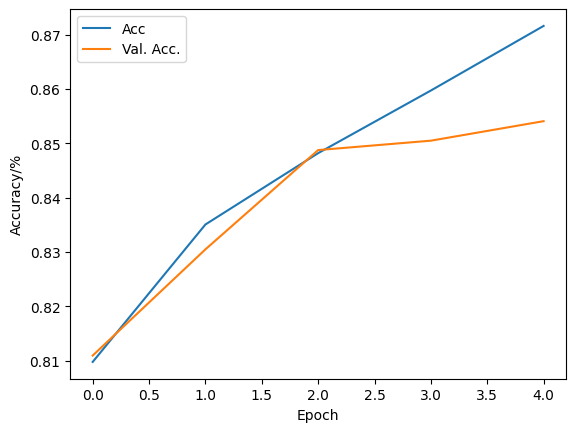

In [108]:
plt.plot(modelfit1.history["Accuracy"], label = "Acc")
plt.plot(modelfit1.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")

Text(0, 0.5, 'Recall/%')

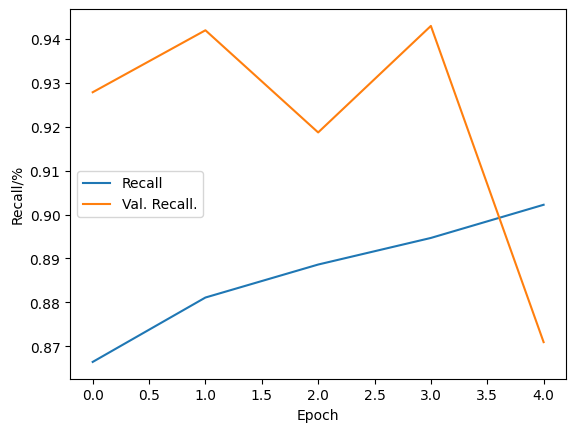

In [111]:
plt.plot(modelfit1.history["recall"], label = "Recall")
plt.plot(modelfit1.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")

Text(0, 0.5, 'precision/%')

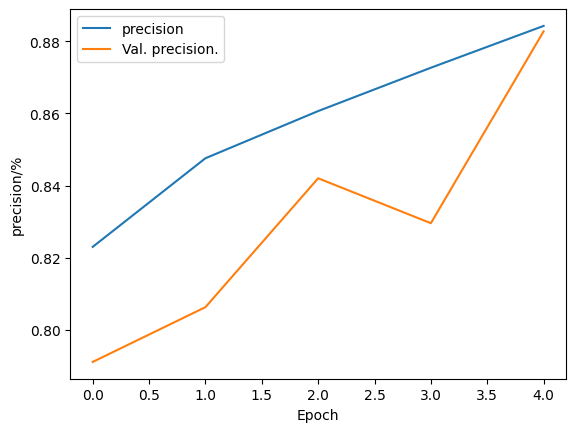

In [112]:
plt.plot(modelfit1.history["precision"], label = "precision")
plt.plot(modelfit1.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")

Text(0, 0.5, 'MSE')

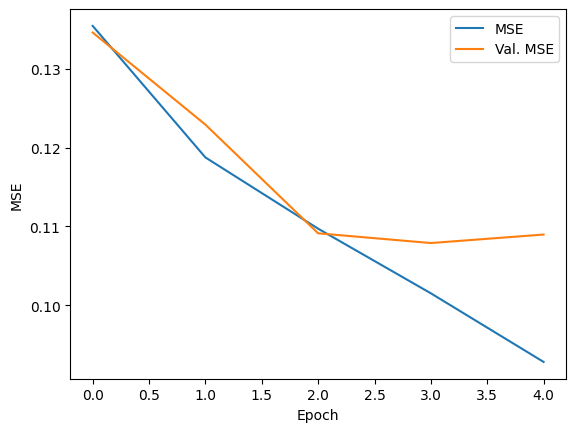

In [109]:
plt.plot(modelfit1.history["MSE"], label = "MSE")
plt.plot(modelfit1.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'AUC')

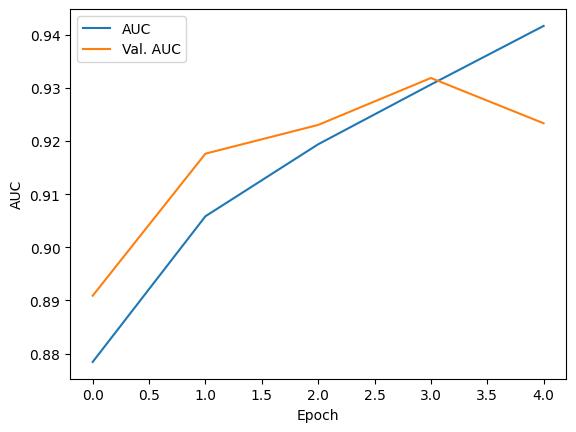

In [114]:
plt.plot(modelfit1.history["auc"], label = "AUC")
plt.plot(modelfit1.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")

So, from the above, we see that the metrics are improving (Acc/Rec/Prec/AUC increasing, MSE decreasing) for the training accuracy from 1 epoch (0) to 5 epochs (4.0). Similarly, it appears to be the case for the validation accuracy and precision; however, the AUC and recall are starting to decrease and thee MSE saturates. Remember that recall is lowered by the false negative rate? We do want to avoid this kind of errors, and it appears that 5 epochs already tend to overfit in this regard.  It might be best to aim for 4 epochs - but how good are we with this model? 85% validation accuracy appears to be quite low, as to be expected for this first model.

## Hyperparameter tuning

### Model 2

Starting from this, we do want to improve on our prediction capabilites. Which hyperparameter should we start of with first? We could start with our layers, their hyperparameters, or the optimizer and loss function. Seeing that we only started with a rather basic Conv-Conv-Pooling approach, let us see how adding another iteration impacts our predictive capabilites:

In [115]:
model2 = Sequential()
model2.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3)))
model2.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [116]:
model2.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [117]:
modelfit2 = model2.fit(
    dataflow_train,
    validation_data = dataflow_vaildation,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 5)

Epoch 1/5
24753/24753 [==============================] - 203s 8ms/step - loss: 0.4388 - Accuracy: 0.7985 - precision: 0.8115 - recall: 0.8614 - auc: 0.8712 - MSE: 0.1408 - val_loss: 0.3593 - val_Accuracy: 0.8446 - val_precision: 0.8653 - val_recall: 0.8757 - val_auc: 0.9187 - val_MSE: 0.1114
Epoch 2/5
24753/24753 [==============================] - 200s 8ms/step - loss: 0.3503 - Accuracy: 0.8482 - precision: 0.8628 - recall: 0.8855 - auc: 0.9205 - MSE: 0.1089 - val_loss: 0.3366 - val_Accuracy: 0.8569 - val_precision: 0.8934 - val_recall: 0.8630 - val_auc: 0.9308 - val_MSE: 0.1032
Epoch 3/5
24753/24753 [==============================] - 199s 8ms/step - loss: 0.3202 - Accuracy: 0.8642 - precision: 0.8751 - recall: 0.9002 - auc: 0.9334 - MSE: 0.0985 - val_loss: 0.3017 - val_Accuracy: 0.8741 - val_precision: 0.8970 - val_recall: 0.8913 - val_auc: 0.9423 - val_MSE: 0.0916
Epoch 4/5
24753/24753 [==============================] - 200s 8ms/step - loss: 0.2991 - Accuracy: 0.8742 - precision: 0.8

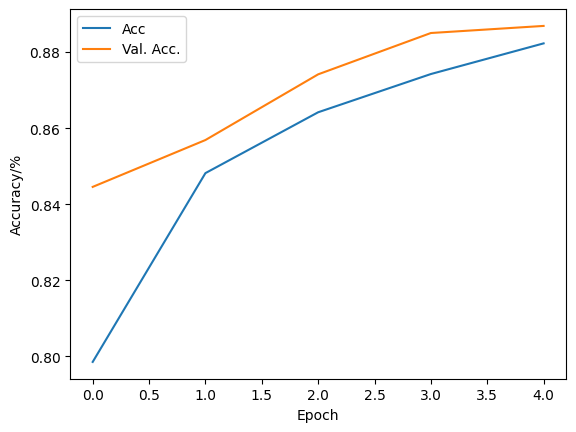

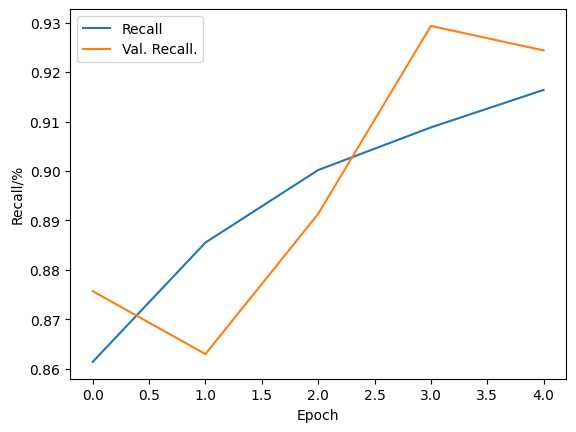

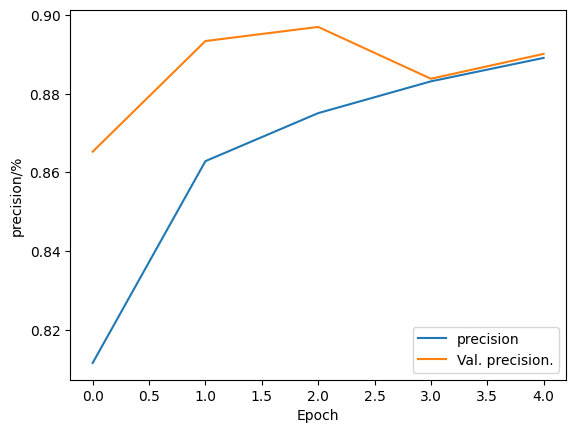

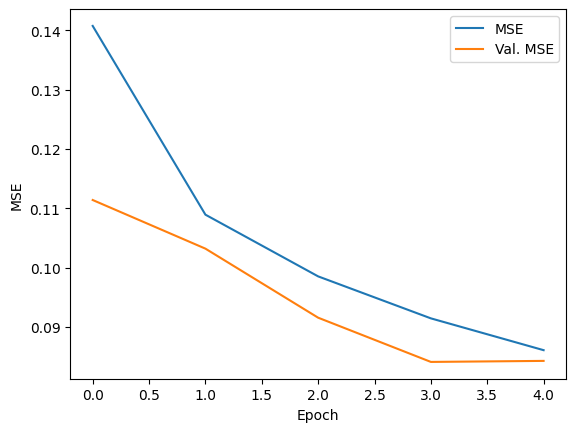

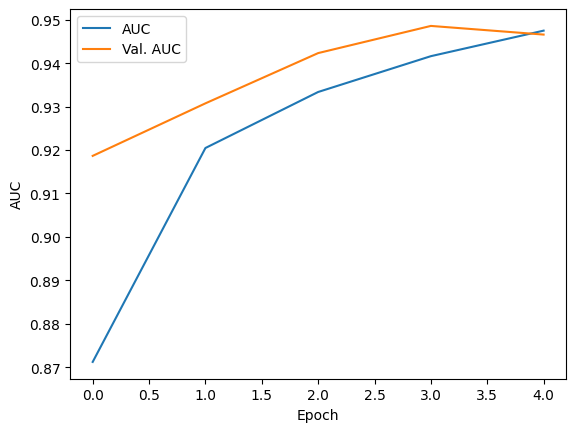

In [120]:
plt.plot(modelfit2.history["Accuracy"], label = "Acc")
plt.plot(modelfit2.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit2.history["recall"], label = "Recall")
plt.plot(modelfit2.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit2.history["precision"], label = "precision")
plt.plot(modelfit2.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit2.history["MSE"], label = "MSE")
plt.plot(modelfit2.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit2.history["auc"], label = "AUC")
plt.plot(modelfit2.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

Let us focus on accuracy and recall, for the time being. We have increased the validation accuracy to 88.7% - and we only see a slight decrease in the recall from epoch 4 to 5. However, the fluctuations may well be due to our batch size being chosen so small. Before continuing on further, we should choose a bigger batch size promising more stable results, and also add another epoch for further evaluation.

### Model 3:

In [121]:
batch_size = 64

In [122]:
dataflow_train2 = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path_train,
    x_col = "id",
    y_col = "label2",
    target_size = (96,96),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    subset = "training",
    seed = 1)

Found 198023 validated image filenames belonging to 2 classes.


In [123]:
dataflow_vaildation2 = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path_train,
    x_col = "id",
    y_col = "label2",
    target_size = (96,96),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    subset = "validation",
    seed = 1)

Found 22002 validated image filenames belonging to 2 classes.


In [124]:
model3 = Sequential()
model3.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3)))
model3.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [125]:
model3.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [126]:
modelfit3 = model3.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 6)

Epoch 1/6
3095/3095 [==============================] - 149s 48ms/step - loss: 0.5086 - Accuracy: 0.7489 - precision: 0.7563 - recall: 0.8526 - auc: 0.8194 - MSE: 0.1685 - val_loss: 0.4441 - val_Accuracy: 0.7969 - val_precision: 0.7886 - val_recall: 0.9011 - val_auc: 0.8722 - val_MSE: 0.1427
Epoch 2/6
3095/3095 [==============================] - 148s 48ms/step - loss: 0.4240 - Accuracy: 0.8103 - precision: 0.8213 - recall: 0.8705 - auc: 0.8806 - MSE: 0.1347 - val_loss: 0.3900 - val_Accuracy: 0.8316 - val_precision: 0.8342 - val_recall: 0.8956 - val_auc: 0.9014 - val_MSE: 0.1216
Epoch 3/6
3095/3095 [==============================] - 147s 48ms/step - loss: 0.3943 - Accuracy: 0.8267 - precision: 0.8381 - recall: 0.8784 - auc: 0.8981 - MSE: 0.1240 - val_loss: 0.3727 - val_Accuracy: 0.8380 - val_precision: 0.8343 - val_recall: 0.9088 - val_auc: 0.9139 - val_MSE: 0.1164
Epoch 4/6
3095/3095 [==============================] - 146s 47ms/step - loss: 0.3732 - Accuracy: 0.8377 - precision: 0.8526 

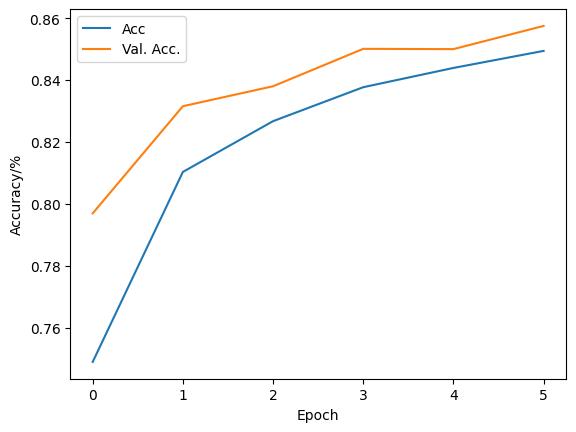

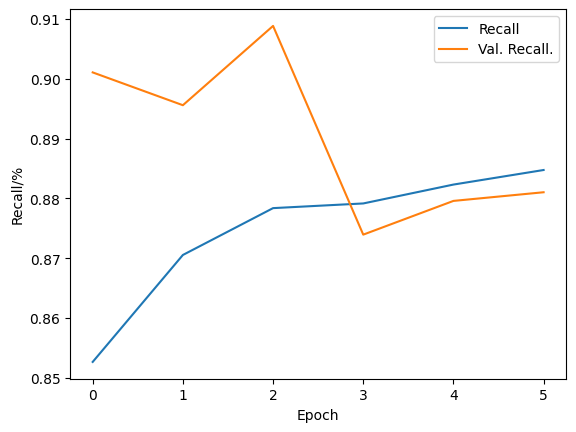

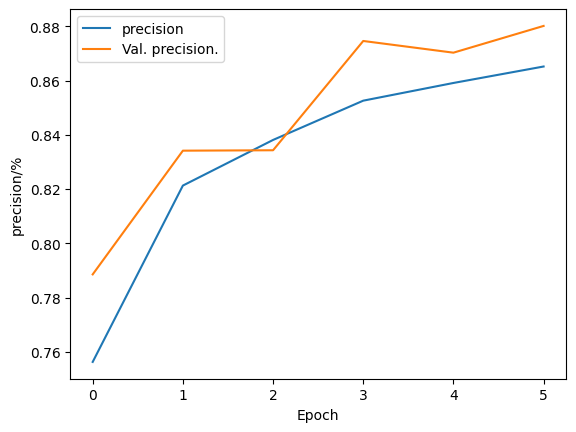

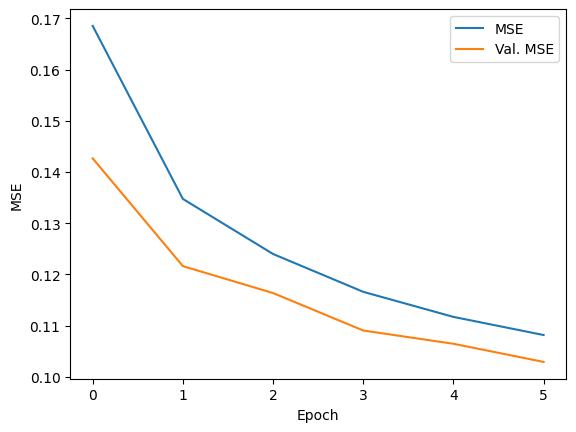

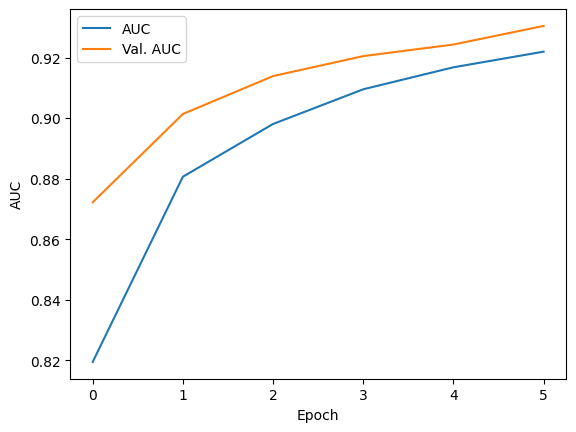

In [127]:
plt.plot(modelfit3.history["Accuracy"], label = "Acc")
plt.plot(modelfit3.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit3.history["recall"], label = "Recall")
plt.plot(modelfit3.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit3.history["precision"], label = "precision")
plt.plot(modelfit3.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit3.history["MSE"], label = "MSE")
plt.plot(modelfit3.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit3.history["auc"], label = "AUC")
plt.plot(modelfit3.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

We see less fluctuation in the metrics, and achieve a validation accuracy short of 86%. Recall appears to decrease in the validation data set with epoch 4.

## Model 4

Now that we are more stable, how about increasing the number of filters for our convolution layers from 16 to 32 - and adding another iteration?

In [128]:
model4 = Sequential()
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3)))
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [129]:
model4.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [130]:
modelfit4 = model4.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 6)

Epoch 1/6
3095/3095 [==============================] - 154s 49ms/step - loss: 0.5709 - Accuracy: 0.6991 - precision: 0.6977 - recall: 0.8718 - auc: 0.7546 - MSE: 0.1944 - val_loss: 0.4646 - val_Accuracy: 0.7865 - val_precision: 0.8230 - val_recall: 0.8178 - val_auc: 0.8557 - val_MSE: 0.1500
Epoch 2/6
3095/3095 [==============================] - 149s 48ms/step - loss: 0.4441 - Accuracy: 0.7990 - precision: 0.8120 - recall: 0.8616 - auc: 0.8672 - MSE: 0.1423 - val_loss: 0.3954 - val_Accuracy: 0.8303 - val_precision: 0.8432 - val_recall: 0.8789 - val_auc: 0.8987 - val_MSE: 0.1236
Epoch 3/6
3095/3095 [==============================] - 147s 48ms/step - loss: 0.4033 - Accuracy: 0.8207 - precision: 0.8318 - recall: 0.8757 - auc: 0.8928 - MSE: 0.1274 - val_loss: 0.3910 - val_Accuracy: 0.8245 - val_precision: 0.8075 - val_recall: 0.9266 - val_auc: 0.9072 - val_MSE: 0.1232
Epoch 4/6
3095/3095 [==============================] - 151s 49ms/step - loss: 0.3812 - Accuracy: 0.8326 - precision: 0.8456 

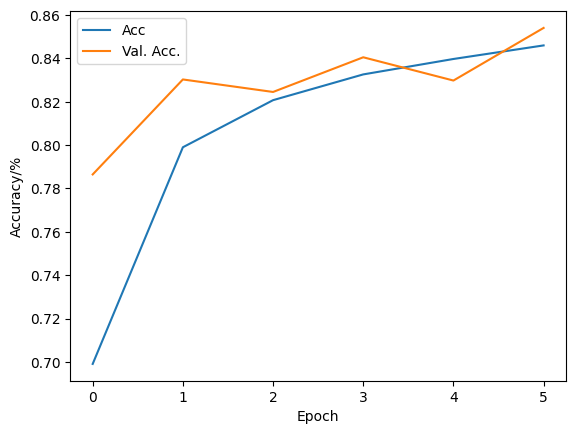

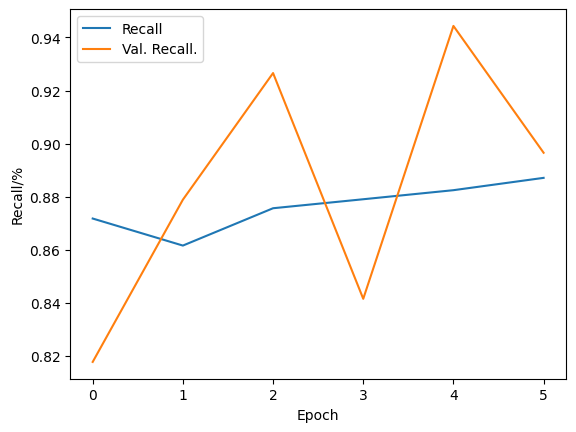

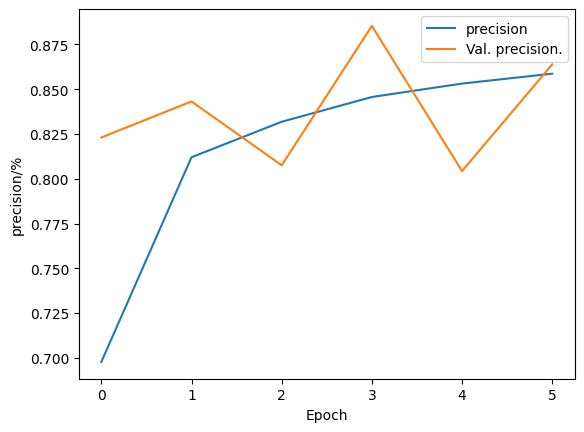

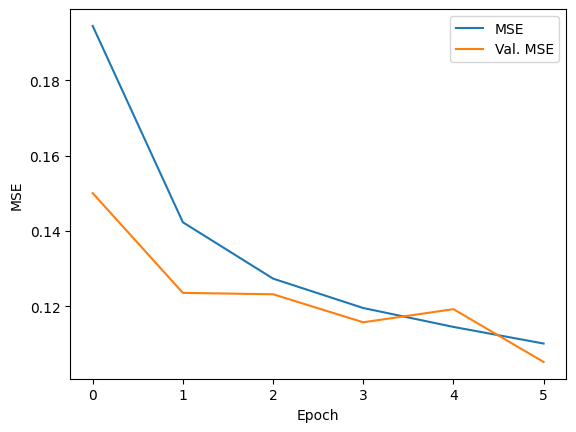

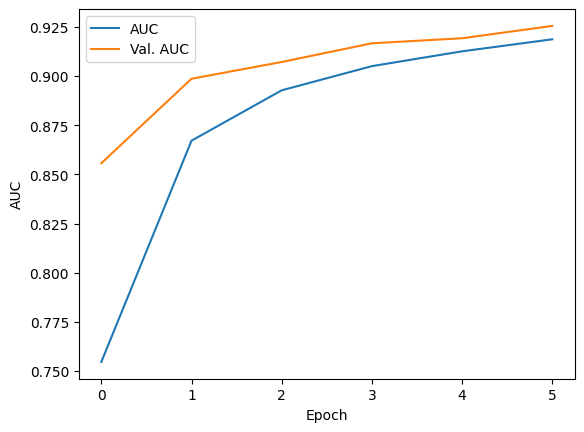

In [131]:
plt.plot(modelfit4.history["Accuracy"], label = "Acc")
plt.plot(modelfit4.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit4.history["recall"], label = "Recall")
plt.plot(modelfit4.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit4.history["precision"], label = "precision")
plt.plot(modelfit4.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit4.history["MSE"], label = "MSE")
plt.plot(modelfit4.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit4.history["auc"], label = "AUC")
plt.plot(modelfit4.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

Now, we see that this did not help our model - in fact, the validation accuracy went down a bit (85.4%). What could have gone wrong? We are decreasing our 'virtual' images in size after each convolution, as Conv2D by default uses no padding. The chosen pooling size cannot compensate for this. We should therefore introduce non-zero padding to our layers! This applies to our pooling layers as well: padding = "same" restores the original size.

# Model 5 - This time with padding!

As argued before, we introduce padding. We also want to increase the numbers of filters to match our dimensions - but we do that in the next iteration to still see whether we improve our accuracy or need to rethink our Conv-Conv-Pooling iterations.

In [132]:
model5 = Sequential()
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3), padding = "same"))
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model5.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model5.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model5.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model5.add(MaxPooling2D(pool_size=(3, 3)))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

In [133]:
model5.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [134]:
modelfit5 = model5.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 6)

Epoch 1/6
3095/3095 [==============================] - 157s 50ms/step - loss: 0.5134 - Accuracy: 0.7438 - precision: 0.7443 - recall: 0.8672 - auc: 0.8146 - MSE: 0.1707 - val_loss: 0.4130 - val_Accuracy: 0.8162 - val_precision: 0.8392 - val_recall: 0.8559 - val_auc: 0.8883 - val_MSE: 0.1302
Epoch 2/6
3095/3095 [==============================] - 153s 49ms/step - loss: 0.4084 - Accuracy: 0.8205 - precision: 0.8304 - recall: 0.8774 - auc: 0.8891 - MSE: 0.1288 - val_loss: 0.3870 - val_Accuracy: 0.8289 - val_precision: 0.8867 - val_recall: 0.8175 - val_auc: 0.9107 - val_MSE: 0.1218
Epoch 3/6
3095/3095 [==============================] - 154s 50ms/step - loss: 0.3712 - Accuracy: 0.8387 - precision: 0.8512 - recall: 0.8831 - auc: 0.9100 - MSE: 0.1161 - val_loss: 0.3418 - val_Accuracy: 0.8522 - val_precision: 0.8740 - val_recall: 0.8790 - val_auc: 0.9245 - val_MSE: 0.1066
Epoch 4/6
3095/3095 [==============================] - 153s 49ms/step - loss: 0.3453 - Accuracy: 0.8494 - precision: 0.8629 

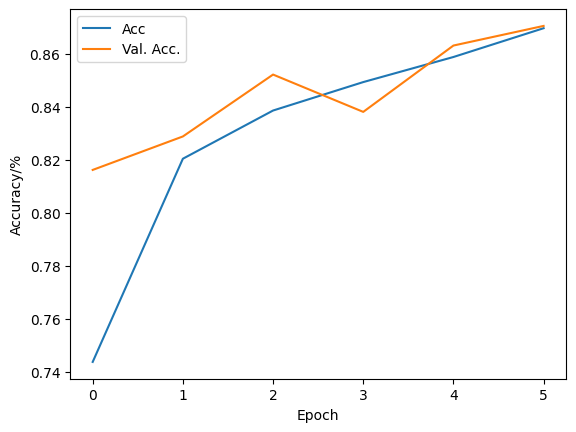

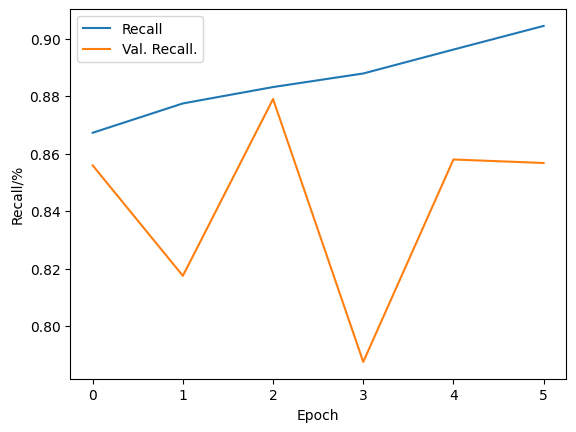

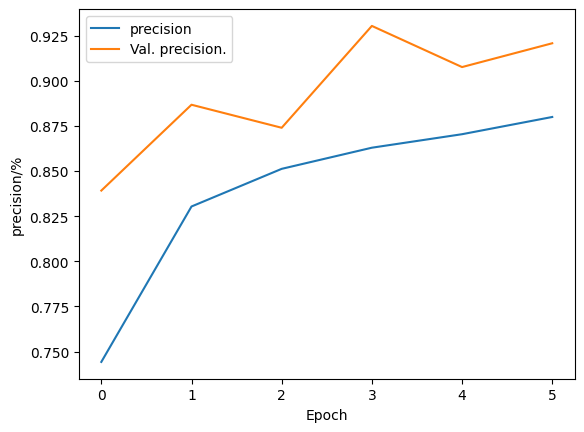

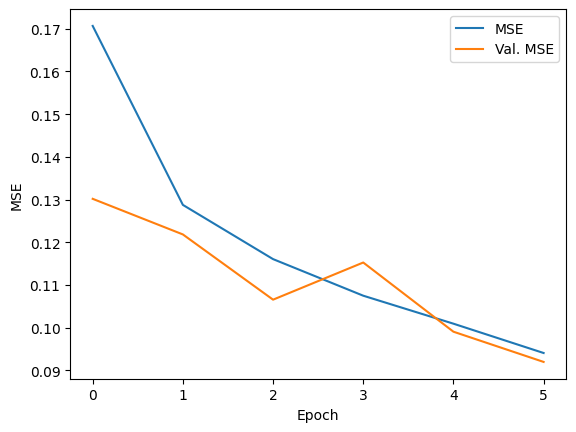

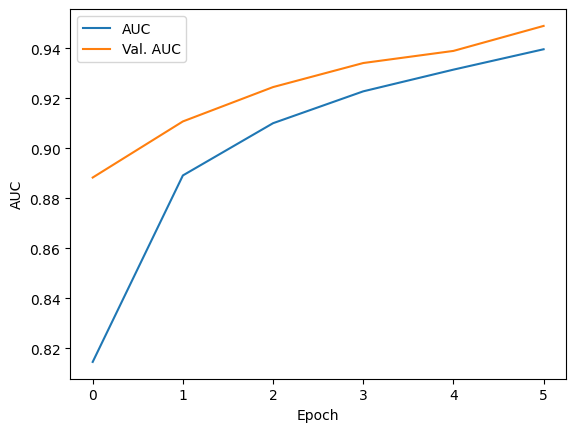

In [135]:
plt.plot(modelfit5.history["Accuracy"], label = "Acc")
plt.plot(modelfit5.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit5.history["recall"], label = "Recall")
plt.plot(modelfit5.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit5.history["precision"], label = "precision")
plt.plot(modelfit5.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit5.history["MSE"], label = "MSE")
plt.plot(modelfit5.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit5.history["auc"], label = "AUC")
plt.plot(modelfit5.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

So, we have improved our model (compared to model 4 and 3!), now yielding 87.0% validation accuracy and 85.7% validation recall! The fluctuations in our validation metrics might still be due to the batch size. We do see, however, that all other training AND validation metrics improve even to the last epoch - we might still try to further train our model. The unreliability of the recall set aside, we try to test 8 epochs with our next model, this time also increasing the filters to match our input dimensions as discussed earlier.

## Model 6: More filters, more epochs

We choose 96 filters for our first filter in each iteration, and increase epochs to 8.

In [136]:
model6 = Sequential()
model6.add(Conv2D(96,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3), padding = "same"))
model6.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model6.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model6.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model6.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model6.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model6.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model6.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding = "same"))
model6.add(MaxPooling2D(pool_size=(3, 3)))
model6.add(Flatten())
model6.add(Dense(64, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

In [137]:
model6.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [138]:
modelfit6 = model6.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 8)

Epoch 1/8
3095/3095 [==============================] - 158s 50ms/step - loss: 0.5205 - Accuracy: 0.7412 - precision: 0.7419 - recall: 0.8662 - auc: 0.8078 - MSE: 0.1732 - val_loss: 0.4281 - val_Accuracy: 0.8086 - val_precision: 0.8530 - val_recall: 0.8204 - val_auc: 0.8838 - val_MSE: 0.1361
Epoch 2/8
3095/3095 [==============================] - 152s 49ms/step - loss: 0.4090 - Accuracy: 0.8198 - precision: 0.8294 - recall: 0.8776 - auc: 0.8892 - MSE: 0.1289 - val_loss: 0.4121 - val_Accuracy: 0.8129 - val_precision: 0.7771 - val_recall: 0.9623 - val_auc: 0.9101 - val_MSE: 0.1307
Epoch 3/8
3095/3095 [==============================] - 153s 49ms/step - loss: 0.3678 - Accuracy: 0.8410 - precision: 0.8551 - recall: 0.8822 - auc: 0.9124 - MSE: 0.1144 - val_loss: 0.3705 - val_Accuracy: 0.8407 - val_precision: 0.8577 - val_recall: 0.8787 - val_auc: 0.9116 - val_MSE: 0.1148
Epoch 4/8
3095/3095 [==============================] - 149s 48ms/step - loss: 0.3451 - Accuracy: 0.8510 - precision: 0.8672 

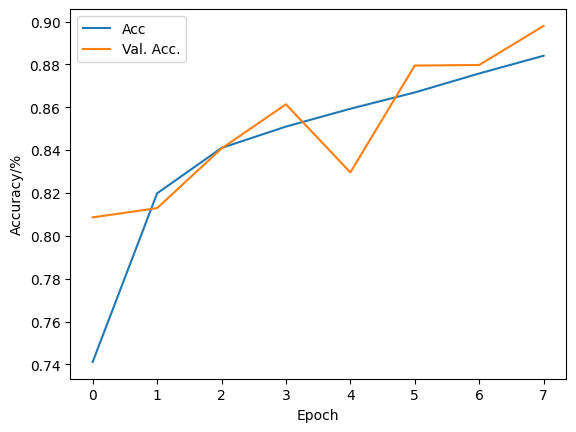

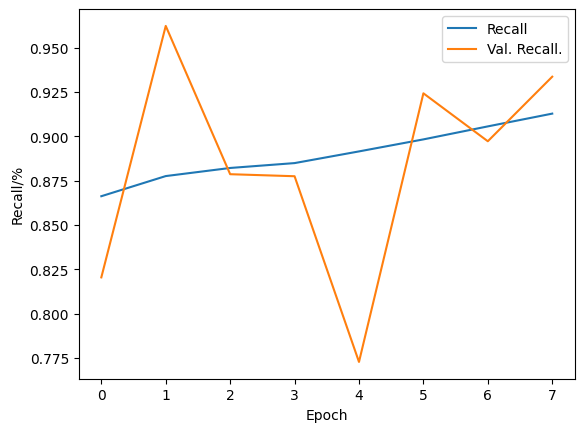

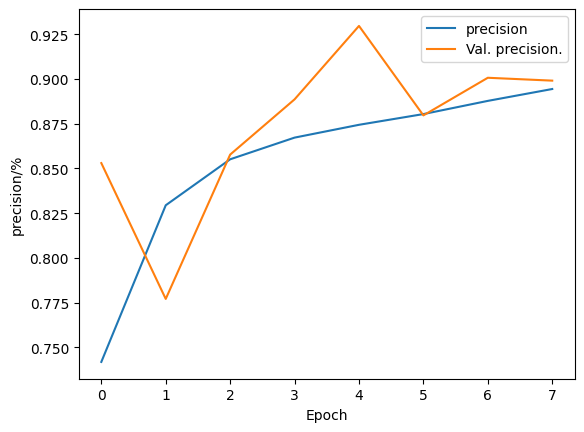

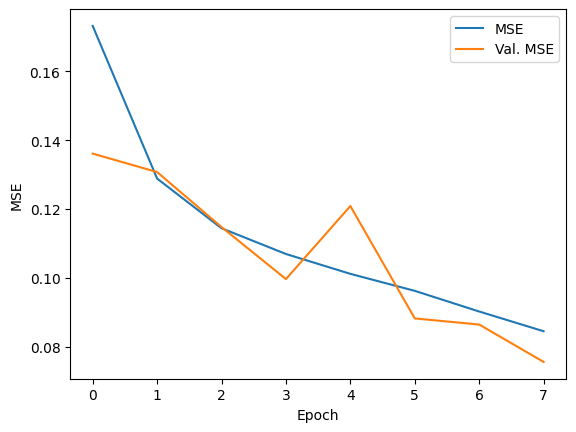

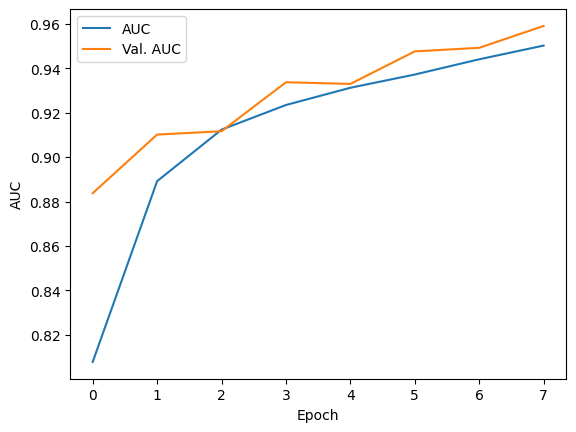

In [139]:
plt.plot(modelfit6.history["Accuracy"], label = "Acc")
plt.plot(modelfit6.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit6.history["recall"], label = "Recall")
plt.plot(modelfit6.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit6.history["precision"], label = "precision")
plt.plot(modelfit6.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit6.history["MSE"], label = "MSE")
plt.plot(modelfit6.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit6.history["auc"], label = "AUC")
plt.plot(modelfit6.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

Compared to the same epochs of our previous model, the metrics are comparable, in particular accuracy - however, we see that the extension of further epochs still do not shows signs of overfitting in the validation data. After 8 epochs, we have 88.4% accuracy on the training and almost 90% on the validation set. We could now continue to further iterate by adding more layers or epochs - or first see whether our layers profit from more filters corresponding to the input shape.

## Model 7: Even more filters

Setting all filters to 96.

In [152]:
model7 = Sequential()
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3), padding = "same"))
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model7.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model7.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model7.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model7.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model7.add(Flatten())
model7.add(Dense(64, activation='relu'))
model7.add(Dense(1, activation='sigmoid'))

In [153]:
model7.compile(
    optimizer ="SGD",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [154]:
modelfit7 = model7.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 8)

Epoch 1/8
3095/3095 [==============================] - 175s 55ms/step - loss: 0.5180 - Accuracy: 0.7428 - precision: 0.7454 - recall: 0.8619 - auc: 0.8096 - MSE: 0.1722 - val_loss: 0.4162 - val_Accuracy: 0.8133 - val_precision: 0.8127 - val_recall: 0.8928 - val_auc: 0.8858 - val_MSE: 0.1320
Epoch 2/8
3095/3095 [==============================] - 169s 54ms/step - loss: 0.4060 - Accuracy: 0.8226 - precision: 0.8306 - recall: 0.8817 - auc: 0.8906 - MSE: 0.1277 - val_loss: 0.4162 - val_Accuracy: 0.8179 - val_precision: 0.8897 - val_recall: 0.7929 - val_auc: 0.9053 - val_MSE: 0.1307
Epoch 3/8
3095/3095 [==============================] - 168s 54ms/step - loss: 0.3677 - Accuracy: 0.8408 - precision: 0.8544 - recall: 0.8827 - auc: 0.9121 - MSE: 0.1145 - val_loss: 0.3651 - val_Accuracy: 0.8369 - val_precision: 0.9132 - val_recall: 0.8027 - val_auc: 0.9268 - val_MSE: 0.1146
Epoch 4/8
3095/3095 [==============================] - 168s 54ms/step - loss: 0.3424 - Accuracy: 0.8522 - precision: 0.8678 

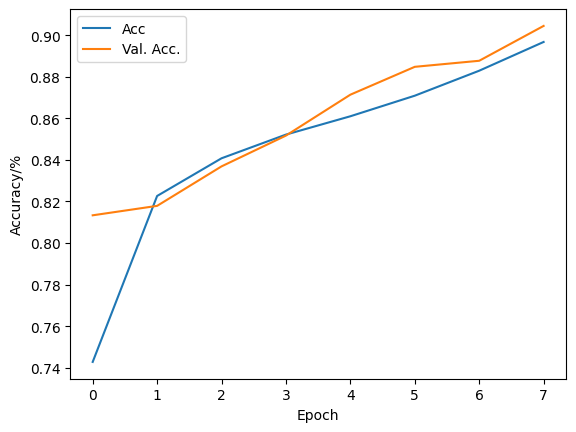

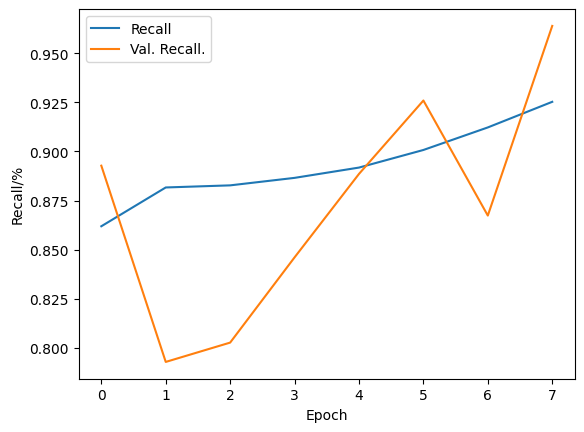

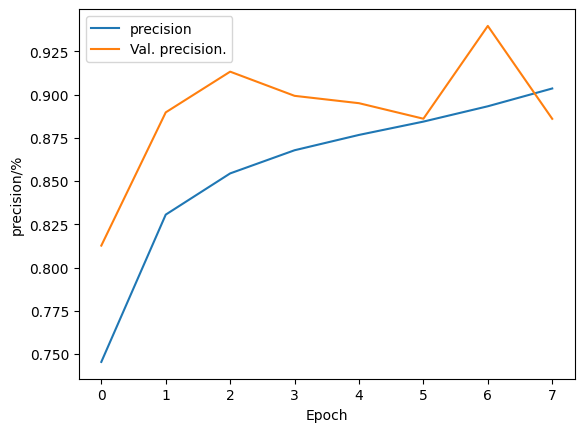

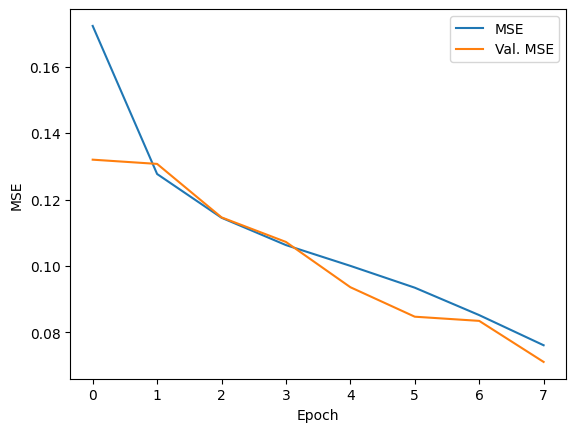

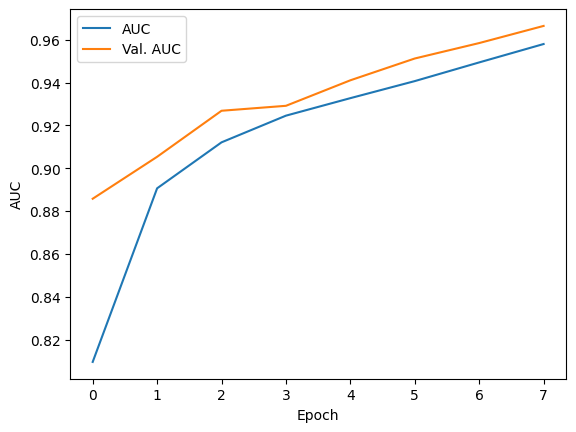

In [155]:
plt.plot(modelfit7.history["Accuracy"], label = "Acc")
plt.plot(modelfit7.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit7.history["recall"], label = "Recall")
plt.plot(modelfit7.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit7.history["precision"], label = "precision")
plt.plot(modelfit7.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit7.history["MSE"], label = "MSE")
plt.plot(modelfit7.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit7.history["auc"], label = "AUC")
plt.plot(modelfit7.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

We do observe a slight increase in training (89.7%) and validation (90.5%) accuracy. All other metrics appear to increase, fluctuations in precision aside.

Having crossed the 90% threshold, it would be time to unleash our model on the testing data and see what score Kaggle gives us - but let us first check whether we have chosen the right optimizer and loss function or if we could do better.

## Model 8: Optimizer function "Adam"

We started with the assumption that Stochastic Gradient Descent and BinaryCrossentropy as Optimizer and Loss Function, respectively, work well enough. However, which impact do they have on our results?
First, let us discuss our optimizer: There are plenty of different optimizers built into TF/Keras that optimize SGD, for example Adam, which is aimed at large data sets. Let's see how our last model benefits from exchanging the optimizer:

In [160]:
model8 = Sequential()
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu',input_shape=(96, 96, 3), padding = "same"))
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model8.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model8.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model8.add(Conv2D(96,kernel_size=(3,3),activation='relu', padding = "same"))
model8.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model8.add(Flatten())
model8.add(Dense(64, activation='relu'))
model8.add(Dense(1, activation='sigmoid'))

In [161]:
model8.compile(
    optimizer ="Adam",
    loss = "BinaryCrossentropy",
    metrics=["Accuracy", "Precision", "Recall", "AUC", "MSE"])

In [162]:
modelfit8 = model8.fit(
    dataflow_train2,
    validation_data = dataflow_vaildation2,
    callbacks = callbacks,
    batch_size = batch_size,
    epochs = 8)

Epoch 1/8
3095/3095 [==============================] - 168s 53ms/step - loss: 0.3697 - Accuracy: 0.8346 - precision: 0.8444 - recall: 0.8849 - auc: 0.9102 - MSE: 0.1167 - val_loss: 0.3144 - val_Accuracy: 0.8681 - val_precision: 0.8409 - val_recall: 0.9606 - val_auc: 0.9444 - val_MSE: 0.0963
Epoch 2/8
3095/3095 [==============================] - 163s 53ms/step - loss: 0.2374 - Accuracy: 0.9052 - precision: 0.9092 - recall: 0.9338 - auc: 0.9623 - MSE: 0.0703 - val_loss: 0.2066 - val_Accuracy: 0.9186 - val_precision: 0.9020 - val_recall: 0.9688 - val_auc: 0.9732 - val_MSE: 0.0601
Epoch 3/8
3095/3095 [==============================] - 163s 53ms/step - loss: 0.1950 - Accuracy: 0.9257 - precision: 0.9276 - recall: 0.9491 - auc: 0.9739 - MSE: 0.0563 - val_loss: 0.2096 - val_Accuracy: 0.9201 - val_precision: 0.9029 - val_recall: 0.9704 - val_auc: 0.9730 - val_MSE: 0.0610
Epoch 4/8
3095/3095 [==============================] - 162s 52ms/step - loss: 0.1714 - Accuracy: 0.9357 - precision: 0.9375 

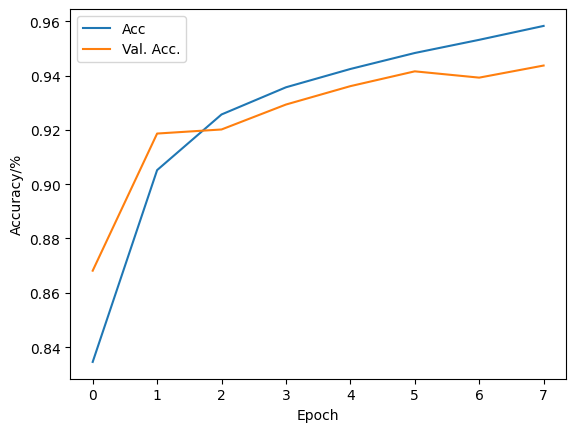

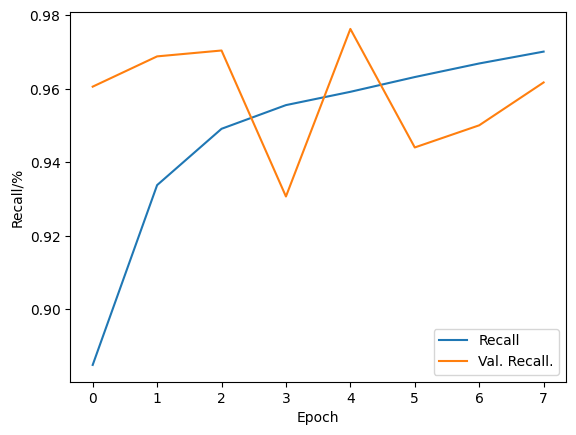

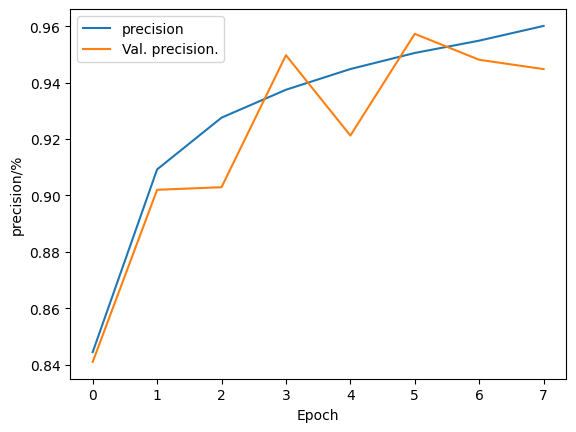

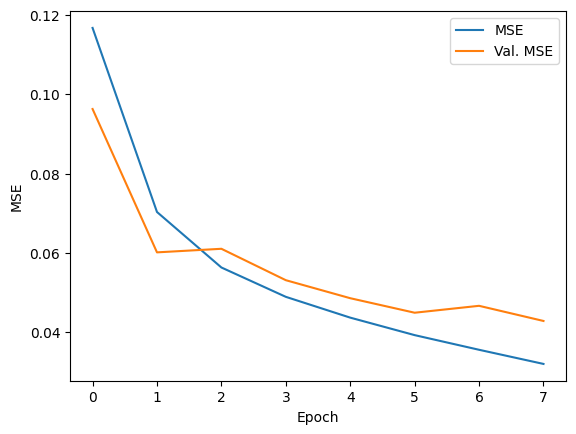

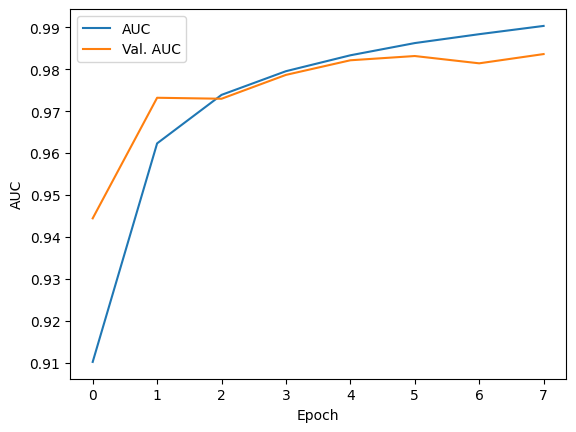

In [163]:
plt.plot(modelfit8.history["Accuracy"], label = "Acc")
plt.plot(modelfit8.history["val_Accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit8.history["recall"], label = "Recall")
plt.plot(modelfit8.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit8.history["precision"], label = "precision")
plt.plot(modelfit8.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit8.history["MSE"], label = "MSE")
plt.plot(modelfit8.history["val_MSE"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.plot(modelfit8.history["auc"], label = "AUC")
plt.plot(modelfit8.history["val_auc"], label = "Val. AUC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

We observe a massive improvement by changing the optimizer from SGD to Adam! In terms of accuracy, we now have after 8 epochs increased to 95.8% (training) and 94.4% (validation). It appears that we still might improve on the model by adding further epochs, as no validation curve shows (fluctuations aside) signs of decreasing - however, the curves are tapering off.

We could also now test the impact of changing or default binary classification loss function. "BinaryFocalCrossentropy" allows to set focal factors to decrease the influence of easy and increase the influence of difficult cases. However, this would require a lot of fine tuning to at least be on par with the present model and would be out of scope for this mini project.

## Applying the model to the test data

Finally, with a promising model at hand, we should predict our test data - and save a CSV so we can upload it to Kaggle for scoring. First, we need to construct our flow for the test data based on the sample submission structure:

In [179]:
sample_submission = pd.read_csv("/content/sample_submission.csv")

In [181]:
len(sample_submission)

57458

In [183]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [186]:
sample_submission["id"] = sample_submission["id"] + ".tif"
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [187]:
dataflow_test2 = datagen.flow_from_dataframe(
    dataframe = sample_submission,
    directory = path_test,
    x_col = "id",
    target_size = (96,96),
    batch_size = 1,
    class_mode=None,
    shuffle = False)

Found 57458 validated image filenames.


In [189]:
prediction = model8.predict(dataflow_test2)

57458/57458 [==============================] - 116s 2ms/step


In [224]:
prediction[0:20]

array([[9.8866594e-01],
       [9.9490559e-01],
       [9.9677461e-01],
       [9.6790200e-01],
       [9.6992862e-01],
       [6.3655637e-02],
       [6.2986267e-01],
       [5.7414766e-02],
       [9.9633658e-01],
       [9.8446029e-01],
       [7.9456121e-02],
       [9.9769336e-01],
       [9.9742150e-01],
       [9.9914360e-01],
       [9.9114448e-01],
       [7.1580398e-05],
       [9.5862508e-01],
       [8.2519579e-01],
       [3.6079224e-02],
       [4.1763313e-04]], dtype=float32)

In [201]:
submission = pd.read_csv("/content/sample_submission.csv")

In [202]:
len(submission)

57458

In [221]:
for i in range(0,len(submission)):
  if (prediction[i] < 0.5):
    submission["label"].iloc[i] = 1
  elif (prediction[i] >= 0.5):
    submission["label"].iloc[i] = 0

Streaming output truncated to the last 5000 lines.
<ipython-input-221-b2af2eec0b34>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["label"].iloc[i] = 0
<ipython-input-221-b2af2eec0b34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["label"].iloc[i] = 1
<ipython-input-221-b2af2eec0b34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["label"].iloc[i] = 1
<ipython-input-221-b2af2eec0b34>:5: SettingWit

In [222]:
submission[0:20]

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,1
6,aa0307865281d4484ddf8c637c348292968b93a7,0
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,1
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0


In [223]:
submission.to_csv("Kaggle_submission.csv", encoding='utf-8', index=False)

When uploading this to Kaggle, the score is 0.8397 (Private) and 0.8581 (Public). This is a decent result, but falls short of the validation accuracy achieved in the model building.

# Summary

Based on the image data, starting from a basic CNN with only one Conv-Conv-Pooling Layer structure, followed by one fully connected NN layer after flattening, different approaches for optimizing the model were taken. Specificially, the number of Conv-Conv-Pooling iterations was increased from 1 to 2 and then 3, and the number of filters of each layer were adapted. Finally, the optimizer was changed from SGD to Adam.
For all models, accuracy, recall, precision, AUC and MSE were observed; however, for the purpose of training the model, accuracy would have sufficed, while the other parameters were only additionally monitored for irregularities.
The accuracy increased with each iteration, with the last model after 8 epochs providing 95.8% (training) and 94.4% (validation) in accuracy.
With 85.8% on the test data (public), still decent results are achieved.

What did not go so well (apart from issues with Google Drive) is that the validation metrics suffer from visible fluctuations, which might be attributed to the batch size (which was increased from 8 to 64), the validation ratio (which was only 10%, but should be sufficient in view of the number of examples) or further causes. This renders evaluation of the validation metrics less reliable.

To further improve the model, first even more epochs could be run, as we do not see a saturation in training metrics and no decrease in the validation metrics (fluctuations aside) - so no overfitting is expected. Then, further tuning of the layers could be performed. Since we do not observe any overfitting effects, dropout regularization need not be performed.
There are also further approaches we have not discussed - for example, an unmodified ImageDataGenerator has been used. One could e. g. test the effects of shifting, rotating or flipping on the model trained.